<a href="https://colab.research.google.com/github/Nishidh25/Covid-19-Detection-from-Lung-X-rays/blob/master/Covid_19_Detection_from_Lung_X_rays.ipynb%20" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading data from kaggle - CoronaHack -Chest X-Ray-Dataset

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

100% 1.18G/1.19G [00:14<00:00, 123MB/s]
100% 1.19G/1.19G [00:14<00:00, 86.4MB/s]


In [2]:
!unzip coronahack-chest-xraydataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0447-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0448-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0449-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0450-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0451-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0452-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001-0002.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0455-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack

# Imports

In [3]:
import os
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D,GlobalMaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Activation, MaxPool2D, AvgPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Reading data to dataframe

In [0]:
df = pd.read_csv('Chest_xray_Corona_Metadata.csv') # CSV containing image name and category
df_summary = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv') # CSV containing info about dataset

In [5]:
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [6]:
df_summary.head()

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4


In [0]:
# Storing TRAIN and TEST data into seperate dataframes
train_data = df[df['Dataset_type'] == 'TRAIN']
test_data = df[df['Dataset_type'] == 'TEST']

In [11]:
test_data.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5286,5309,IM-0021-0001.jpeg,Normal,TEST,NaN,NaN
5287,5310,IM-0019-0001.jpeg,Normal,TEST,NaN,NaN
5288,5311,IM-0017-0001.jpeg,Normal,TEST,NaN,NaN
5289,5312,IM-0016-0001.jpeg,Normal,TEST,NaN,NaN
5290,5313,IM-0015-0001.jpeg,Normal,TEST,NaN,NaN


In [0]:
# Filling NaN values with 'missing'
train = train_data.fillna('missing')
test = test_data.fillna('missing')

## Adding a column-'Covid' to the TRAIN dataframe , 
* if Label is Normal - negative 
* if Label is 'Pnemonia' and 'Label_2_Virus_category' - positive 

In [0]:
final_train_data = train[(train['Label'] == 'Normal') | ((train['Label'] == 'Pnemonia') & (train['Label_2_Virus_category'] == 'COVID-19'))]

final_train_data['Covid'] = ['negative' if holder == 'Normal' else 'positive' for holder in final_train_data['Label']]

In [14]:
# Total number of covid X-rays in TRAIN set - 58
final_train_data.loc[final_train_data['Covid'] == 'positive'].count() 

Unnamed: 0                58
X_ray_image_name          58
Label                     58
Dataset_type              58
Label_2_Virus_category    58
Label_1_Virus_category    58
Covid                     58
dtype: int64

In [0]:
final_train_data.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,Covid
0,0,IM-0128-0001.jpeg,Normal,TRAIN,missing,missing,negative
1,1,IM-0127-0001.jpeg,Normal,TRAIN,missing,missing,negative
2,2,IM-0125-0001.jpeg,Normal,TRAIN,missing,missing,negative
3,3,IM-0122-0001.jpeg,Normal,TRAIN,missing,missing,negative
4,4,IM-0119-0001.jpeg,Normal,TRAIN,missing,missing,negative


## X-Ray image Visualization

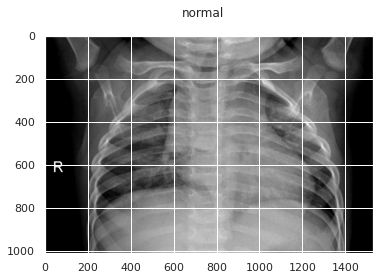

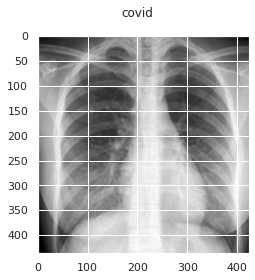

In [56]:
# Normal X-ray
fig = plt.figure()
fig.suptitle('normal')
plt.imshow(mpimg.imread("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0128-0001.jpeg"), cmap='gray') 

# Covid X-ray 
fig = plt.figure()
fig.suptitle('covid')
plt.imshow(mpimg.imread("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/kjr-21-e25-g001-l-a.jpg"), cmap='gray') 

## Splitting TRAIN data into train and validation 
80-20 split

In [0]:
X_train = final_train_data # Changing variable 
y_train = final_train_data["Covid"] # Not needed since we are going to load data from dataframe, only used for train_test_split 

X_test = test 

In [0]:
 X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, shuffle=True)

In [0]:
# Directories of the images
test_image_dir = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
train_image_dir = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'

## Image Augmentation using ImageDataGenerator

In [49]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.5, 
)

test_image_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=X_train,
    directory=train_image_dir,
    x_col='X_ray_image_name',
    y_col='Covid',
    batch_size=16,
    shuffle=True,
    class_mode='binary',
    target_size=(224, 224)
)

validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=X_val,
    directory=train_image_dir,
    x_col='X_ray_image_name',
    y_col='Covid',
    batch_size=16,
    shuffle=True,
    class_mode='binary',
    target_size=(224, 224)
)

test_generator = test_image_generator.flow_from_dataframe(
    dataframe=X_test ,
    directory=test_image_dir,
    x_col='X_ray_image_name',
    shuffle=False,
    batch_size=16,
    class_mode=None,
    target_size=(224, 224))

Found 1120 validated image filenames belonging to 2 classes.
Found 280 validated image filenames belonging to 2 classes.
Found 624 validated image filenames.


In [0]:
model = Sequential([
        
        # Layers 1 and 2 
        Conv2D(64, (3, 3), padding='same',input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
        BatchNormalization(),
        
        # Layers 3 and 4 
        Conv2D(128, (3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
        BatchNormalization(),
    
        # Layers 5 and 6  
        Conv2D(256, (3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
        BatchNormalization(),
    
        # Layers 7 and 8  
        Conv2D(512, (3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
        BatchNormalization(),
    
        # Layer 9 
        Flatten(),
        
        # Layer 10 
        Dense(128, activation='relu'),
        Dropout(0.25),
        
        # Layer 11 
        Dense(256, activation='relu'),
        Dropout(0.25),
        
        # Layer 12  
        Dense(512, activation='relu'),
        Dropout(0.25),
    
        # Layer 13 
        Dense(1024, activation='relu'),
        Dropout(0.25),
        
        # Layer 14
        Dense(1, activation ="sigmoid")    
        ])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < 0.2):
      print("\n Reached val_loss < 0.2")
      self.model.stop_training = True

In [25]:
epochs = 20
Callback =  myCallback()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model.fit(train_generator,
                   validation_data=validation_generator,
                   epochs=epochs,
                   shuffle=True, callbacks = Callback)

Epoch 1/20
70/70 [==============================] - 48s 681ms/step - loss: 1.1123 - accuracy: 0.9268 - val_loss: 0.2840 - val_accuracy: 0.9214
Epoch 2/20
70/70 [==============================] - 48s 680ms/step - loss: 0.7844 - accuracy: 0.9375 - val_loss: 0.2597 - val_accuracy: 0.9393
Epoch 3/20
70/70 [==============================] - 47s 675ms/step - loss: 0.3966 - accuracy: 0.9375 - val_loss: 1.2033 - val_accuracy: 0.0857
Epoch 4/20
70/70 [==============================] - 47s 677ms/step - loss: 0.2805 - accuracy: 0.9491 - val_loss: 1.1761 - val_accuracy: 0.0607
Epoch 5/20
70/70 [==============================] - 47s 676ms/step - loss: 0.1827 - accuracy: 0.9563 - val_loss: 1.0651 - val_accuracy: 0.0786
Epoch 6/20
70/70 [==============================] - 47s 678ms/step - loss: 0.1196 - accuracy: 0.9616 - val_loss: 2.1730 - val_accuracy: 0.0643
Epoch 7/20
70/70 [==============================] - 47s 676ms/step - loss: 0.0996 - accuracy: 0.9696 - val_loss: 0.2228 - val_accuracy: 0.9286

# Graphs

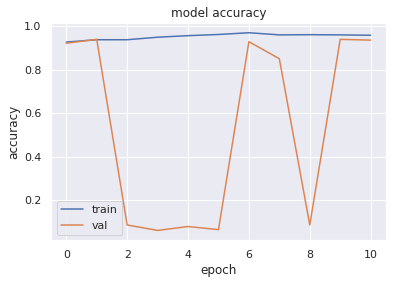

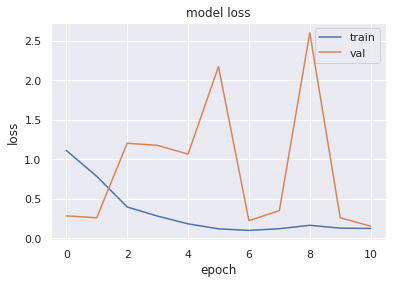

In [26]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='bottom right')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [0]:
#model.save("model.h5")

# Results

This model detects 
* 42+15 = 57/58 positive cases from train data 
* 77 positive casesfrom test data 


In [50]:
train_generator.reset() 
pred=model.predict(train_generator,verbose=1)
labels = (pred > 0.5).astype(np.int)
np.count_nonzero(labels)

70/70 [==============================] - 37s 530ms/step


42

In [46]:
validation_generator.reset()
pred=model.predict(validation_generator,verbose=1)
labels = (pred > 0.5).astype(np.int)
np.count_nonzero(labels)

18/18 [==============================] - 9s 493ms/step


15

In [51]:
test_generator.reset()
pred=model.predict(test_generator,verbose=1)
labels = (pred > 0.5).astype(np.int)
np.count_nonzero(labels)

39/39 [==============================] - 6s 158ms/step


77